In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir("../")

In [2]:
!pip install emukit
!pip install pyDOE

In [4]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [26]:
# import matplotlib.pyplot as plt
# import numpy as np
# from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
# from emukit.core.initial_designs import RandomDesign
# from emukit.core.initial_designs.latin_design import LatinDesign
# from GPy.models import GPRegression
# from emukit.model_wrappers import GPyModelWrapper
# import GPy
# from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
# import time

import matplotlib.pyplot as plt
import numpy as np
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
import time
import random
from sklearn import tree
from sklearn.datasets import make_friedman2
from emukit.quadrature.methods import VanillaBayesianQuadrature
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, EntropySearch
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
import subprocess
from sklearn.gaussian_process import GaussianProcessRegressor
from skopt import gp_minimize

ModuleNotFoundError: No module named 'skopt'

In [ ]:
from emukit.core.interfaces import IModel, IDifferentiable

class SklearnGPModel(IModel,IDifferentiable):
    def __init__(self, sklearn_model):
        self.model = sklearn_model

    def predict(self, X):
        mean, std = self.model.predict(X, return_std=True)
        return mean[:, None], np.square(std)[:, None]

    def set_data(self, X: np.ndarray, Y: np.ndarray) -> None:
        self.model.fit(X, Y)

    def optimize(self, verbose: bool = False) -> None:
        # There is no separate optimization routine for sklearn models
        pass
    
    

    @property
    def X(self) -> np.ndarray:
        return self.model.X_train_

    @property
    def Y(self) -> np.ndarray:
        return self.model.y_train_



# Loading in Data

In [6]:
num_experiments = 100
parameter_list_small = ['gamma', 'gradnoise']
parameter_list =  ['season_duration', 'gamma', 'mut_rate', 'T', 'target_area', 'gradnoise']
parameter_space_small = ParameterSpace([
                                DiscreteParameter('gamma',list(range(0,25))),
                                ContinuousParameter('gradnoise',0.25,0.99)])
parameter_space = ParameterSpace([DiscreteParameter('season_duration',list(range(100,1001,10))), 
                                 DiscreteParameter('gamma',list(range(0,25))), 
                                 ContinuousParameter('mut_rate',0,0.5),
                                 ContinuousParameter('T',1,100),
                                 DiscreteParameter('target_area',list(range(1,101))),
                                 ContinuousParameter('gradnoise',0.25,0.99)])
                      

In [7]:
file_names = ["latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

file_names_small = ["gradient_latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files_small = ["gradient_latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [20]:
def extract_data(file_names,data_files,parameter_list, output_function):
    X = get_parameter_array(file_names,parameter_list)

    # Some files have no data; don't get those
    unrun_files = get_no_data(data_files) 
    X_no_data = X[unrun_files,:]

    X = np.delete(X,unrun_files,axis=0)
    
    all_data = [read_data(file_name) for i,file_name in enumerate(data_files) if i not in unrun_files]
    Y = get_rewards(data_files,lambda s: len(s))
    
    run_to_completion = Y>5000
    X_full, Y_full = X[run_to_completion.flatten(),:], Y[run_to_completion.flatten()]
    X_full[0,:] = np.lcm(X_full[0,:].astype(int),25)
    
    data_full = [data for i,data in enumerate(all_data) if run_to_completion[i,0] == True]
    num_blob_data = np.array([[output_function(data,j) for j in range(0,50000,1000)] for data in data_full])
    
    return X_full, num_blob_data

In [22]:
X, num_blob_data = extract_data(file_names,data_files,parameter_list, num_blobs_cells)

In [23]:
X, weighted_blob_size_data = extract_data(file_names,data_files,parameter_list, weighted_blobsize_cells) 

In [24]:
print(X.shape)
print(num_blob_data.shape)

(75, 6)
(75, 50)


# 1. Decision Trees (based off Multicellularity over time's notebook)

### 1a. Comparing decision trees for num_blob_cells at start vs. end of simulation (replicating work in multicellularity over time's)

Plot tree classifier for beginning of simulation (MCS = 0)

In [25]:
X_tree_nblob= X
Y_tree_nblob = num_blob_data[:,0].reshape(len(num_blob_data),1)

clf_nblob = tree.DecisionTreeClassifier()
clf_nblob.fit(X_tree_nblob,Y_tree_nblob)

NameError: name 'tree' is not defined

In [ ]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf_nblob,fontsize=12)

In [ ]:
clf_nblob.feature_importances_

In [ ]:
Y_tree_rounded_nblob = np.digitize(Y_tree_nblob,[0,20,100])
clf_nblob = tree.DecisionTreeClassifier()
clf_nblob.fit(X_tree_nblob,Y_tree_rounded_nblob)

In [ ]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf_nblob,fontsize=12)

Plot tree classifier for end of simulation (MCS = 50k)

DecisionTreeClassifier()

### 1b. Comparing decision trees for weighted_blob_size at start vs. end of simulation (replicating work in multicellularity over time's)

Plot tree classifier for beginning of simulation (MCS = 0)

Plot tree classifier for end of simulation (MCS = 50k)

# 2. Sensitivity Analysis on final values

### 2a. SA on num_blob cells, GP fit, and SA from there

### 2b. SA on weighted_blob_size cells, GP fit, and SA from there

In [23]:
# Get an Emukit Model by fitting X,Y from Gaussian Process Regression

ls = 1
var = 1.0
kernel1 = GPy.kern.RBF(input_dim = X.shape[1], lengthscale=ls, variance=var)

noise_var = Y[:, 0].var()*0.01

gpy_model = GPy.models.GPRegression(X, Y, kernel1, normalizer = True, noise_var=noise_var)
emukit_model = GPyModelWrapper(gpy_model)

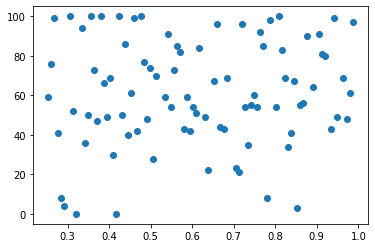

In [30]:
plt.scatter(X[:, 5], Y)

# SA for simulated data

In [35]:
from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity

np.random.seed(10)  # for reproducibility

num_monte_carlo_points = 10000  # Number of MC samples
sensitivity_cell_evol = ModelFreeMonteCarloSensitivity(function_at_last_time(num_blobs_cells), X)
main_effects, total_effects, total_variance = sensitivity_cell_evol.compute_effects(num_monte_carlo_points = num_monte_carlo_points)
print(main_effects)

AttributeError: 'numpy.ndarray' object has no attribute 'sample_uniform'

# Defining and training an emulator for this data

# SA with samples from Emulator